Module importieren

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
from fitter import Fitter
import numpy as np
from scipy import stats
import statsmodels.api as sm
from tabulate import tabulate

Daten laden und säubern

In [ ]:
def open_csv_to_df(directory):
    df = pd.read_csv(directory)
    df = df.iloc[0:,:4]
    df.columns = ["Date", "Time", "Mass_(kg)", "Velocity_(m/s)"]
    df.insert(4, "Energy", "")
    df.insert(5, "Date_and_Time", "")
    df.insert(6, "Time_delta_(h)", "")
    for i in range(len(df)):
        df.iloc[i,4] = 0.5 * float(df.iloc[i,2]) * float(df.iloc[i,3]) ** 2 / 1000 #calculation of Energy
    df = df.sort_values(['Date', 'Time']).reset_index(drop=True)
    df = df.dropna()

    for i in range(len(df)):
        date_raw = df.iloc[i,:].Date +" " +df.iloc[i,:].Time
        date1 = datetime.strptime(date_raw, '%Y-%m-%d %H:%M')
        df.iloc[i,5] = date1

    for i in range(len(df)-1):
        date1 = df.iloc[i,5]
        date2 = df.iloc[i+1,5]
        time_delta = date2 - date1
        time_delta = (time_delta.days*24) + (time_delta.seconds//3600)
        df.iloc[i+1,6] = time_delta

    #Fitter kann keine NAs handhaben aus diesem Grund wird erste Beobachtung mit dem Median der Zeitabstände ersetzt.
    df.iloc[0,6] = 0
    df['Time_delta_(h)'] = df['Time_delta_(h)'].astype('int')
    df.iloc[0,6] = df["Time_delta_(h)"].median()

    return df #this is the table with all stones combined

In [ ]:
df1 = open_csv_to_df("./out_1.csv")
df2 = open_csv_to_df("./out_2.csv")

Modellierung

In [ ]:
def goodness_of_fit(data):
    # Verteilungsfunktionen definieren
    distributions = ['norm', 'expon', 'lognorm', 'gamma', 'chi2', 'cauchy']

    # Werte gleichmässig auf X-Achse verteilen
    x = np.linspace(min(data), max(data), 1_000)

    # ECDF von den definierten Verteilungsfunktionen erstellen
    for distribution in distributions:
        param = eval('stats.' + distribution + '.fit(data)')
        sample = eval('stats.' + distribution + '.cdf(x, *param)')
        plt.plot(x, sample)

    # ECDF ploten
    plt.hist(data, cumulative=True, density=True, bins=200, color='#5384A6')
    plt.xlim([data.min(), data.max()])
    plt.xlabel(data.head().name)
    plt.ylabel('F(x)')
    plt.legend(distributions, loc='lower right')
    plt.title('Empirische kumulative Verteilungsfunktion von ' + data.head().name)

    # QQ-Plots für die Verteilungsfunktionen erstellen und ploten
    count = 0
    fig, ax = plt.subplots(1, len(distributions), figsize=(25, 5))
    fig.suptitle('Quantil-Quantil Plots der angepassten Verteilungsfunktionen und ' + data.head().name, fontsize=16)

    for distribution in distributions:
        param = eval('stats.' + distribution + '.fit(data)')
        sample = eval('stats.' + distribution + '.rvs(*param, size = 10000)')
        sm.qqplot_2samples(data, sample, xlabel=distribution.capitalize() + ' Verteilung', ylabel='Probe Verteilung', line='45', ax=ax[count])
        count += 1

## Zone 1
### Masse

Gamma

In [ ]:
goodness_of_fit(df1['Mass_(kg)'])

### Geschwindigkeit
Normalverteilung

In [ ]:
goodness_of_fit(df1["Velocity_(m/s)"])

### Zeitabstand
Exponential

In [ ]:
goodness_of_fit(df1["Time_delta_(h)"])

## Zone 2
### Masse
Exponential

In [ ]:
goodness_of_fit(df2['Mass_(kg)'])

### Geschwindigkeit
Normalverteilung

In [ ]:
goodness_of_fit(df2["Velocity_(m/s)"])

### Zeitabstand
Exponential

In [ ]:
goodness_of_fit(df2["Time_delta_(h)"])

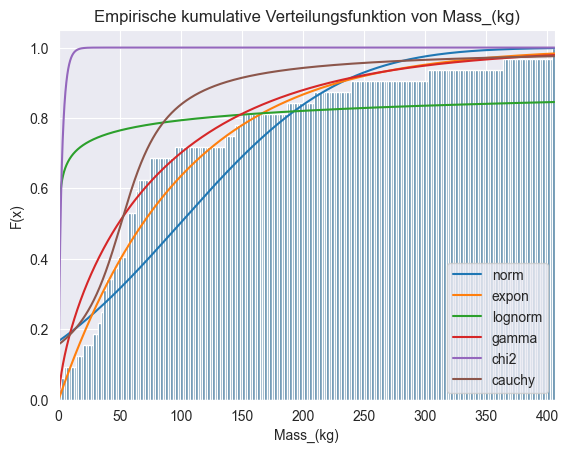

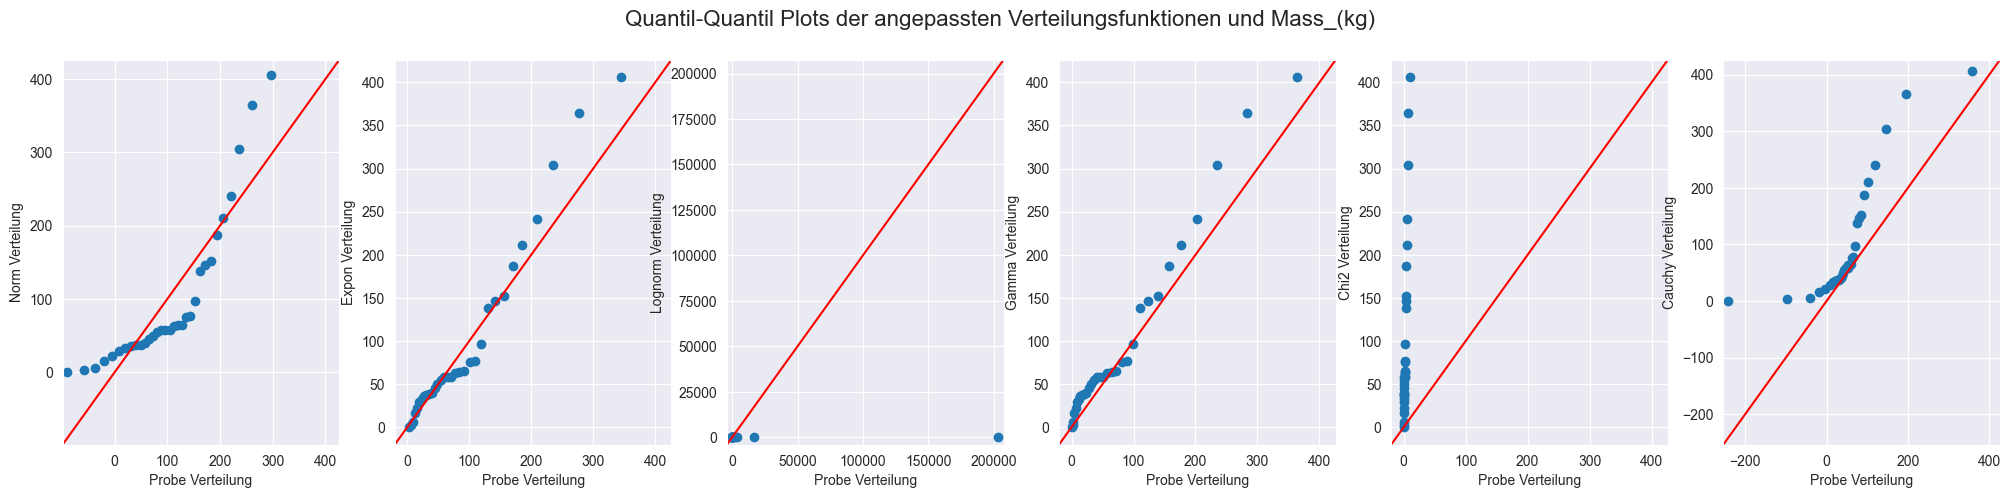

In [18]:
goodness_of_fit(df2['Mass_(kg)'])

### Geschwindigkeit
Normalverteilung

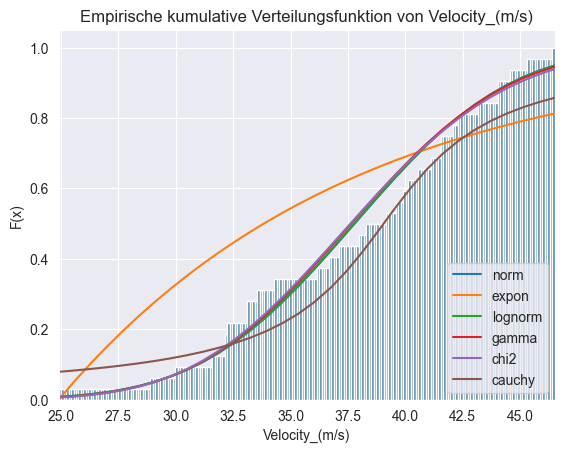

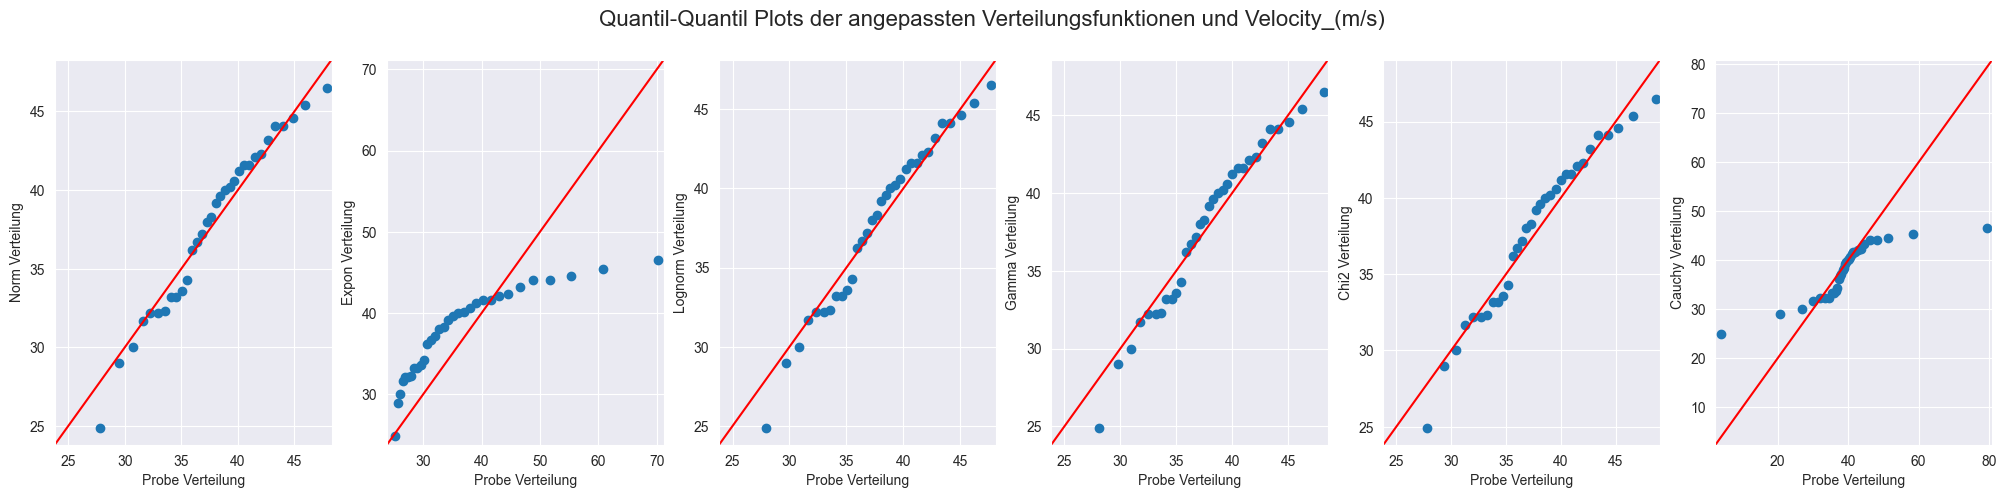

In [10]:
goodness_of_fit(df2["Velocity_(m/s)"])

### Zeitabstand
Exponential

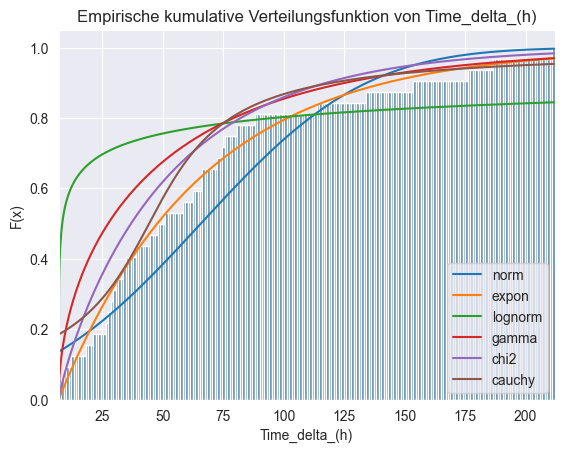

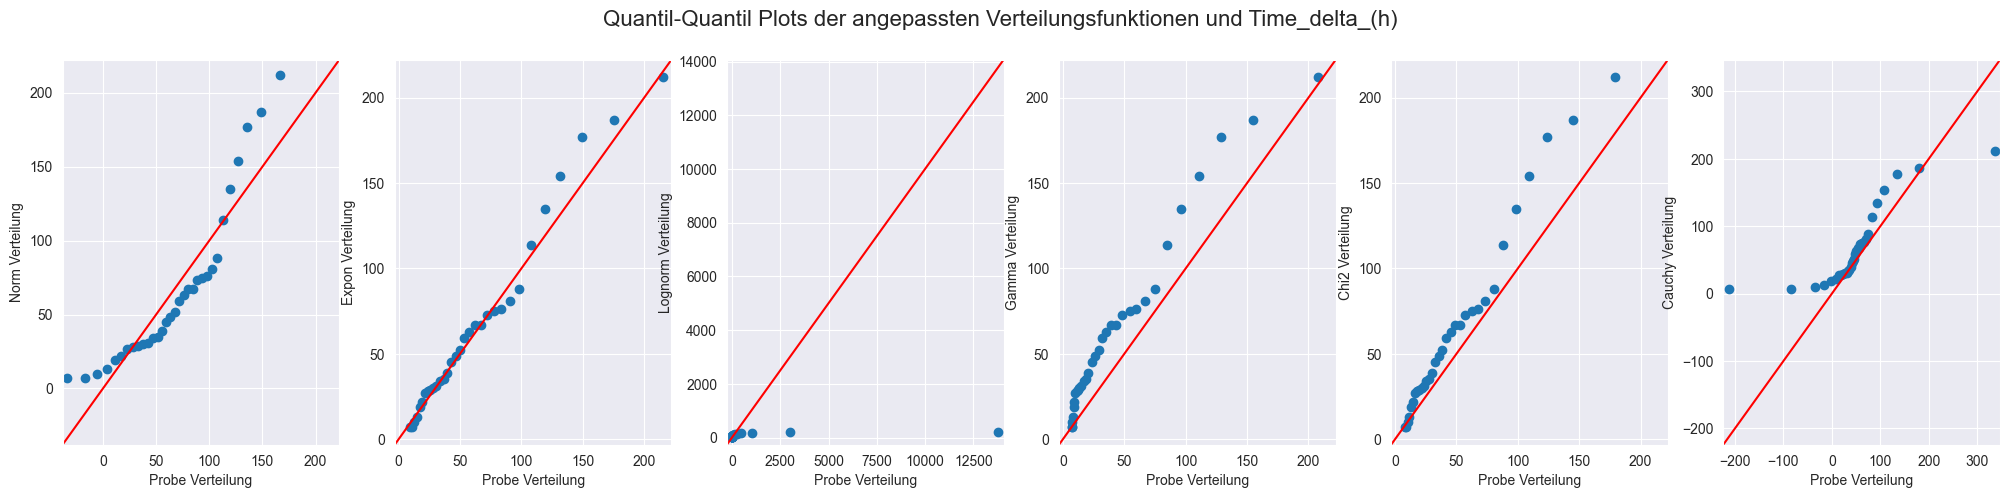

In [28]:
goodness_of_fit(df2["Time_delta_(h)"])

Monte Carlo

In [12]:
def plot_verteilung(dataframe, x_val):
    sns.set_style("white")
    sns.set_context("paper", font_scale = 1.5)
    sns.displot(data = dataframe, x = x_val, kind = "hist", bins = 150, aspect = 3.0)

Zone 1

In [104]:
mass1_sim = stats.norminvgauss.rvs(3.1212660746620413, 3.049636729092045, 34.65446329649014, 129.49172019279249, size = 1000000)
df1_mass_sim = pd.DataFrame(mass1_sim)
velocity1_sim = stats.norminvgauss.rvs(8.815229190843102, -1.1717104407578982, 9.56468292816113, 5.789676074259544, size = 1000000)
df1_velocity_sim = pd.DataFrame(velocity1_sim)
timedelta1_sim = stats.chi.rvs(0.6466917035616518, -8.620646255400194e-27, 50.086113926689904, size = 1000000)
df1_timedelta_sim = pd.DataFrame(timedelta1_sim)
#df1_mass_sim[df1_mass_sim[0] < 0][0]

Zone 2

In [16]:
mass2_sim = stats.skewcauchy.rvs(0.5654845478523323, 31.009036433794673, 28.383685799048294, size = 1000000)
df2_mass_sim = pd.DataFrame(mass2_sim)
velocity2_sim = stats.beta.rvs(2.135456049863241, 1.2827668923945292, 23.092130432299154, 23.56888476645474, size = 1000000)
df2_velocity_sim = pd.DataFrame(velocity2_sim)
timedelta2_sim = stats.expon.rvs(7.0, 59.322580645161295, size = 1000000)
df2_timedelta_sim = pd.DataFrame(timedelta2_sim)

In [107]:
df1_sim = pd.DataFrame()
df1_sim.insert(0, "Date", "")
df1_sim.insert(1, "Mass_(kg)", mass1_sim)
df1_sim.insert(2, "Velocity_(m/s)", velocity1_sim)
df1_sim.insert(3, "Energy", "")
df1_sim.insert(4, "Time_delta_(h)", timedelta1_sim)

df1_sim["Time_delta_(h)"][0] = 0
df1_sim["Time_delta_(h)"] = pd.to_timedelta(df1_sim['Time_delta_(h)'], unit='hour')

df1_sim.Date[0] = datetime.strptime("2019-01-01 00:00", '%Y-%m-%d %H:%M')
max_s = 31556926
current_s = 0
i = 1

while (current_s < max_s):
    df1_sim["Date"][i] =  df1_sim["Date"][i-1] + df1_sim["Time_delta_(h)"][i]
    current_s = current_s + int(df1_sim["Time_delta_(h)"][i].seconds) + int(df1_sim["Time_delta_(h)"][i].days)*86400
    i += 1

df1_sim = df1_sim.dropna()
for i in range(len(df1_sim)):
        df1_sim.iloc[i,3] = 0.5 * float(df1_sim.iloc[i,1]) * float(df1_sim.iloc[i,2]) ** 2 / 1000

C:\Users\logan\AppData\Local\Temp\ipykernel_4932\2038886911.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_sim["Time_delta_(h)"][0] = 0
C:\Users\logan\AppData\Local\Temp\ipykernel_4932\2038886911.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_sim.Date[0] = datetime.strptime("2019-01-01 00:00", '%Y-%m-%d %H:%M')
C:\Users\logan\AppData\Local\Temp\ipykernel_4932\2038886911.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c